<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/1_5_Assignment_4_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
#https://www.kaggle.com/code/tilasousa/face-mask-detection-using-keras-cnn

# Import Libraries

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import cv2
from scipy.spatial import distance
import glob
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import classification_report , confusion_matrix
from skimage import io
filterwarnings("ignore")

from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow_datasets as tfds
from keras import callbacks
from sklearn.metrics import accuracy_score
from os import listdir
from os.path import isfile, join

In [99]:
## Accuracy and Loss Graph
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

## Validation Report
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

## Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

# defining callback function to avoid overfit
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 6, 
                                        restore_best_weights = True, verbose=1)

# EDA

The path is created for getting data and then I concatened dataframes of mask and without mask.

In [100]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [101]:
!unzip -u 'gdrive/My Drive/MSDS 458/Assignment 4 - Final/Data/archive.zip' -d 'gdrive/MyDrive/MSDS 458/Assignment 4 - Final/Data/'

Archive:  gdrive/My Drive/MSDS 458/Assignment 4 - Final/Data/archive.zip


In [102]:
path  = '/content/gdrive/My Drive/MSDS 458/Assignment 4 - Final/Data/Face Mask Dataset/'

In [103]:
# train dataset
train_dir = os.path.join(path, 'Train')

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 10000 files belonging to 2 classes.


In [104]:
# validation dataset
validation_dir = os.path.join(path, 'Validation')

validation_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 800 files belonging to 2 classes.


In [105]:
# test dataset
test_dir = os.path.join(path, 'Test')

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 992 files belonging to 2 classes.


In [106]:
class_names = train_ds.class_names
print(class_names)

['WithMask', 'WithoutMask']


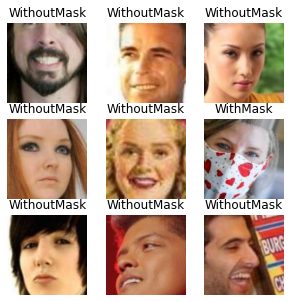

In [107]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [108]:
# autotune buffer to avoid I/0 block
autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=autotune)
validation_ds = validation_ds.cache().prefetch(buffer_size=autotune)

# Model 1

Sequential model

Input layer

Hidden layer 1: Dense 100 units, Relu activation

Hidden layer 2: Dense 150 units, Relu activation

Output layer: Dense 2 units, Softmax activation

In [109]:
model1 = Sequential()
tf.keras.layers.Rescaling(1./255),
model1.add(keras.layers.Flatten(input_shape = [256, 256, 3]))
model1.add(layers.Dense(units = 100, activation = "relu"))
model1.add(layers.Dense(units = 150, activation = "relu"))
model1.add(layers.Dense(name = "output_layer", units = 2, activation = "softmax"))

model1.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 196608)            0         
                                                                 
 dense_36 (Dense)            (None, 100)               19660900  
                                                                 
 dense_37 (Dense)            (None, 150)               15150     
                                                                 
 output_layer (Dense)        (None, 2)                 302       
                                                                 
Total params: 19,676,352
Trainable params: 19,676,352
Non-trainable params: 0
_________________________________________________________________


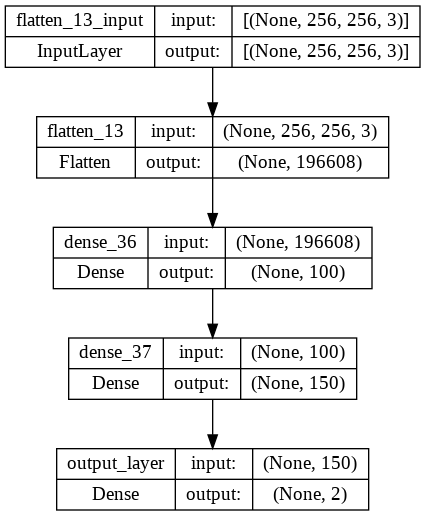

In [110]:
keras.utils.plot_model(model1, "model1.png", show_shapes=True) 

In [111]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [112]:
## Train 
history1 = model1.fit(train_ds
                    ,validation_data =validation_ds
                    ,epochs=200
                    ,batch_size=64
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model1.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                    ]                                                                                                           
                   )

Epoch 1/200
313/313 [==============================] - 8s 24ms/step - loss: 408.6010 - accuracy: 0.8211 - val_loss: 117.5360 - val_accuracy: 0.7750
Epoch 2/200
313/313 [==============================] - 3s 10ms/step - loss: 87.8680 - accuracy: 0.8600 - val_loss: 13.4666 - val_accuracy: 0.9300
Epoch 3/200
313/313 [==============================] - 3s 10ms/step - loss: 9.3202 - accuracy: 0.9111 - val_loss: 6.9539 - val_accuracy: 0.8850
Epoch 4/200
313/313 [==============================] - 3s 9ms/step - loss: 6.0572 - accuracy: 0.9159 - val_loss: 28.9713 - val_accuracy: 0.5950
Epoch 5/200
313/313 [==============================] - 3s 10ms/step - loss: 9.6860 - accuracy: 0.8962 - val_loss: 2.6473 - val_accuracy: 0.6225


In [113]:
model1 = tf.keras.models.load_model("DNN_model1.h5")
print(f"Test acc: {model1.evaluate(test_ds)[1]:.3f}")

31/31 [==============================] - 1s 16ms/step - loss: 3.7119 - accuracy: 0.6109
Test acc: 0.611


## Evaluate

In [114]:
history_dict1 = history1.history
history_dict1.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [115]:
history_df1=pd.DataFrame(history_dict1)
history_df1.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,408.601,0.821,117.536,0.775
1,87.868,0.860,13.467,0.930
2,9.320,0.911,6.954,0.885
3,6.057,0.916,28.971,0.595
4,9.686,0.896,2.647,0.623


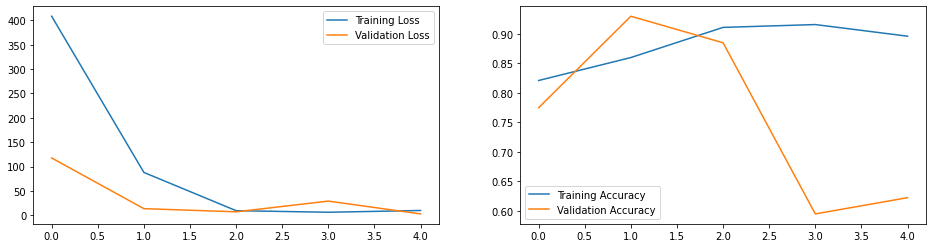

In [116]:
## Loss and acuracy
plot_history(history1)

In [117]:
test_pred1 = model1.predict(test_ds)
test_pred1 = np.argmax(test_pred1,axis = 1)
test_labels1 = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 1s 17ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

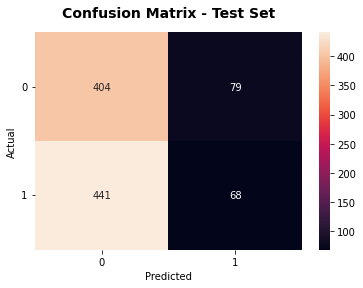

In [118]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels1,
    test_pred1,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [119]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 446 with mask and 55 without mask

# Model 2

Sequential model

Input layer

Hidden layer 1: Dense 250 units, Relu activation

Hidden layer 2: Dense 350 units, Relu activation

Output layer: Dense 2 units, Softmax activation

In [120]:
model2 = Sequential()
tf.keras.layers.Rescaling(1./255),
model2.add(keras.layers.Flatten(input_shape = [256, 256, 3]))
model2.add(layers.Dense(units = 250, activation = "relu"))
model2.add(layers.Dense(units = 350, activation = "relu"))
model2.add(layers.Dense(name = "output_layer", units = 2, activation = "softmax"))

model2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 196608)            0         
                                                                 
 dense_38 (Dense)            (None, 250)               49152250  
                                                                 
 dense_39 (Dense)            (None, 350)               87850     
                                                                 
 output_layer (Dense)        (None, 2)                 702       
                                                                 
Total params: 49,240,802
Trainable params: 49,240,802
Non-trainable params: 0
_________________________________________________________________


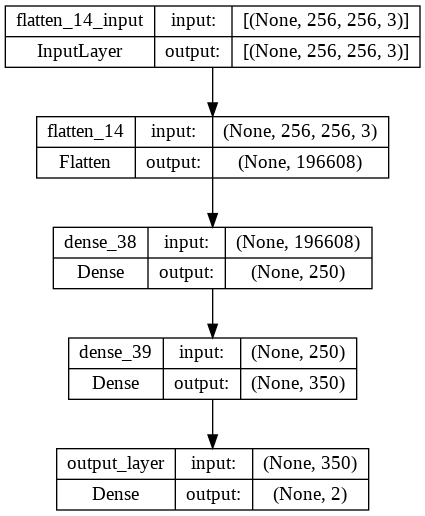

In [121]:
keras.utils.plot_model(model2, "model2.png", show_shapes=True) 

In [122]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [123]:
## Train 
history2 = model2.fit(train_ds
                    ,validation_data =validation_ds
                    ,epochs=200
                    ,batch_size=64
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model2.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                    ]                                                                                                           
                   )

Epoch 1/200
313/313 [==============================] - 5s 14ms/step - loss: 610.1788 - accuracy: 0.8007 - val_loss: 116.0720 - val_accuracy: 0.6913
Epoch 2/200
313/313 [==============================] - 4s 13ms/step - loss: 29.6335 - accuracy: 0.8476 - val_loss: 0.6577 - val_accuracy: 0.6900
Epoch 3/200
313/313 [==============================] - 4s 14ms/step - loss: 0.5689 - accuracy: 0.6658 - val_loss: 0.4907 - val_accuracy: 0.7450
Epoch 4/200
313/313 [==============================] - 4s 14ms/step - loss: 0.3213 - accuracy: 0.8347 - val_loss: 0.2682 - val_accuracy: 0.8300
Epoch 5/200
313/313 [==============================] - 4s 13ms/step - loss: 0.2564 - accuracy: 0.8894 - val_loss: 0.2273 - val_accuracy: 0.8863
Epoch 6/200
313/313 [==============================] - 3s 10ms/step - loss: 0.2922 - accuracy: 0.8873 - val_loss: 0.6757 - val_accuracy: 0.5000
Epoch 7/200
313/313 [==============================] - 3s 10ms/step - loss: 0.6611 - accuracy: 0.5400 - val_loss: 0.6303 - val_accu

In [124]:
model2 = tf.keras.models.load_model("DNN_model2.h5")
print(f"Test acc: {model2.evaluate(test_ds)[1]:.3f}")

31/31 [==============================] - 1s 17ms/step - loss: 0.2193 - accuracy: 0.8861
Test acc: 0.886


## Evaluate

In [125]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [126]:
history_df2=pd.DataFrame(history_dict2)
history_df2.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
3,0.321,0.835,0.268,0.830
4,0.256,0.889,0.227,0.886
5,0.292,0.887,0.676,0.500
6,0.661,0.540,0.630,0.586
7,0.648,0.573,0.673,0.530


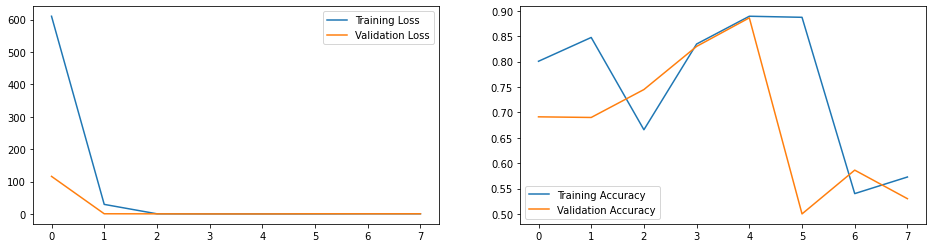

In [127]:
## Loss and acuracy
plot_history(history2)

In [128]:
test_pred2 = model2.predict(test_ds)
test_pred2 = np.argmax(test_pred2,axis = 1)
test_labels2 = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 1s 16ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

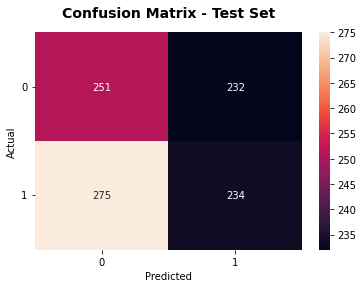

In [129]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels2,
    test_pred2,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [130]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 72 with mask and 399 without mask

# Model 3 - best 85%

Sequential model

Input layer

Hidden layer 1: Dense 250 units, Relu activation

Hidden layer 2: Dense 350 units, Relu activation

Hidden layer 3: Dense 250 units, Relu activation

Hidden layer 4: Dense 100 units, Relu activation

Output layer: Dense 2 units, Softmax activation

In [131]:
model3 = Sequential()
tf.keras.layers.Rescaling(1./255),
model3.add(keras.layers.Flatten(input_shape = [256, 256, 3]))
model3.add(layers.Dense(units = 250, activation = "relu"))
model3.add(layers.Dense(units = 350, activation = "relu"))
model3.add(layers.Dense(units = 250, activation = "relu"))
model3.add(layers.Dense(units = 100, activation = "relu"))
model3.add(layers.Dense(name = "output_layer", units = 2, activation = "softmax"))

model3.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 196608)            0         
                                                                 
 dense_40 (Dense)            (None, 250)               49152250  
                                                                 
 dense_41 (Dense)            (None, 350)               87850     
                                                                 
 dense_42 (Dense)            (None, 250)               87750     
                                                                 
 dense_43 (Dense)            (None, 100)               25100     
                                                                 
 output_layer (Dense)        (None, 2)                 202       
                                                                 
Total params: 49,353,152
Trainable params: 49,353,152

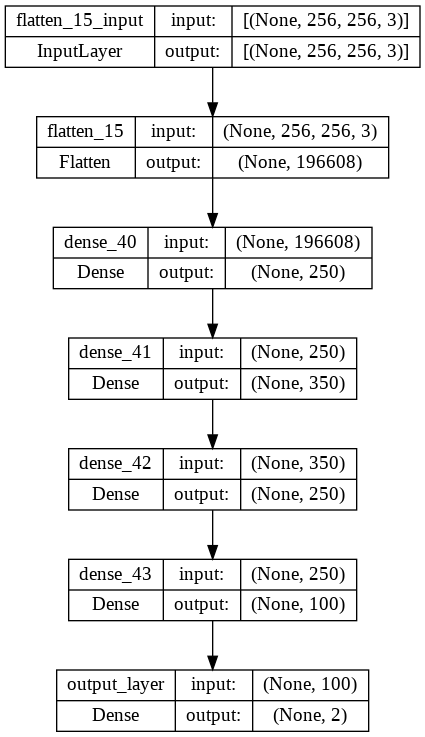

In [132]:
keras.utils.plot_model(model3, "model3.png", show_shapes=True) 

In [133]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [134]:
## Train 
history3 = model3.fit(train_ds
                    ,validation_data =validation_ds
                    ,epochs=200
                    ,batch_size=64
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model3.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                    ]                                                                                                           
                   )

Epoch 1/200
313/313 [==============================] - 5s 14ms/step - loss: 640.7034 - accuracy: 0.7775 - val_loss: 220.8101 - val_accuracy: 0.5437
Epoch 2/200
313/313 [==============================] - 4s 14ms/step - loss: 23.1820 - accuracy: 0.8743 - val_loss: 14.0430 - val_accuracy: 0.9250
Epoch 3/200
313/313 [==============================] - 4s 13ms/step - loss: 16.7125 - accuracy: 0.8945 - val_loss: 6.1597 - val_accuracy: 0.9013
Epoch 4/200
313/313 [==============================] - 3s 10ms/step - loss: 16.8991 - accuracy: 0.8913 - val_loss: 58.2379 - val_accuracy: 0.8825
Epoch 5/200
313/313 [==============================] - 4s 14ms/step - loss: 33.3994 - accuracy: 0.6640 - val_loss: 0.5486 - val_accuracy: 0.6800


In [135]:
model3 = tf.keras.models.load_model("DNN_model3.h5")
print(f"Test acc: {model3.evaluate(test_ds)[1]:.3f}")

31/31 [==============================] - 1s 16ms/step - loss: 5.6535 - accuracy: 0.6986
Test acc: 0.699


## Evaluate

In [136]:
history_dict3 = history3.history
history_dict3.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [137]:
history_df3=pd.DataFrame(history_dict3)
history_df3.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,640.703,0.777,220.810,0.544
1,23.182,0.874,14.043,0.925
2,16.712,0.895,6.160,0.901
3,16.899,0.891,58.238,0.882
4,33.399,0.664,0.549,0.680


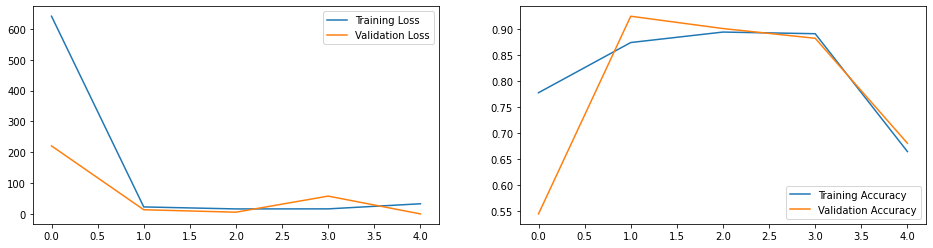

In [138]:
## Loss and acuracy
plot_history(history3)

In [139]:
test_pred3 = model3.predict(test_ds)
test_pred3 = np.argmax(test_pred3,axis = 1)
test_labels3 = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 1s 16ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

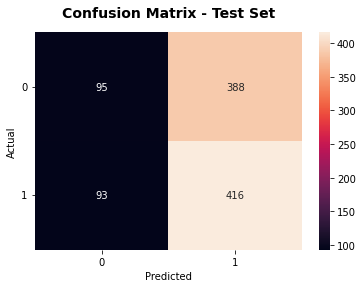

In [140]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels3,
    test_pred3,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [141]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 299 with mask and 194 without mask

# Model 4

Sequential model

Input layer

Hidden layer 1: Dense 250 units, Sigmoid activation

Hidden layer 2: Dense 350 units, Sigmoid activation

Hidden layer 3: Dense 250 units, Sigmoid activation

Hidden layer 4: Dense 100 units, Sigmoid activation

Output layer: Dense 2 units, Softmax activation

In [142]:
model4 = Sequential()
tf.keras.layers.Rescaling(1./255),
model4.add(keras.layers.Flatten(input_shape = [256, 256, 3]))
model4.add(layers.Dense(units = 250, activation = "sigmoid"))
model4.add(layers.Dense(units = 350, activation = "sigmoid"))
model4.add(layers.Dense(units = 250, activation = "sigmoid"))
model4.add(layers.Dense(units = 100, activation = "sigmoid"))
model4.add(layers.Dense(name = "output_layer", units = 2, activation = "softmax"))

model4.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_16 (Flatten)        (None, 196608)            0         
                                                                 
 dense_44 (Dense)            (None, 250)               49152250  
                                                                 
 dense_45 (Dense)            (None, 350)               87850     
                                                                 
 dense_46 (Dense)            (None, 250)               87750     
                                                                 
 dense_47 (Dense)            (None, 100)               25100     
                                                                 
 output_layer (Dense)        (None, 2)                 202       
                                                                 
Total params: 49,353,152
Trainable params: 49,353,152

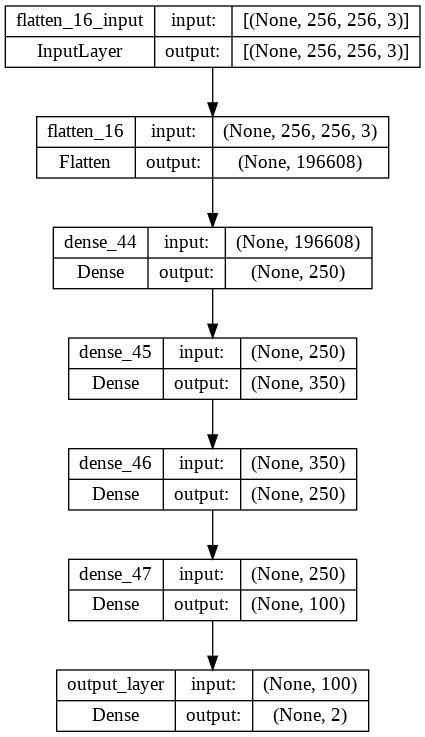

In [143]:
keras.utils.plot_model(model4, "model4.png", show_shapes=True) 

In [144]:
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [145]:
## Train 
history4 = model4.fit(train_ds
                    ,validation_data =validation_ds
                    ,epochs=200
                    ,batch_size=64
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model4.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                    ]                                                                                                           
                   )

Epoch 1/200
313/313 [==============================] - 5s 14ms/step - loss: 0.6995 - accuracy: 0.4969 - val_loss: 0.6950 - val_accuracy: 0.5025
Epoch 2/200
313/313 [==============================] - 4s 14ms/step - loss: 0.6956 - accuracy: 0.5054 - val_loss: 0.6945 - val_accuracy: 0.5025
Epoch 3/200
313/313 [==============================] - 4s 14ms/step - loss: 0.6956 - accuracy: 0.5046 - val_loss: 0.6940 - val_accuracy: 0.5025
Epoch 4/200
313/313 [==============================] - 4s 14ms/step - loss: 0.6953 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.5025


In [146]:
model4 = tf.keras.models.load_model("DNN_model4.h5")
print(f"Test acc: {model4.evaluate(test_ds)[1]:.3f}")

31/31 [==============================] - 1s 17ms/step - loss: 0.6931 - accuracy: 0.5131
Test acc: 0.513


## Evaluate

In [147]:
history_dict4 = history4.history
history_dict4.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [148]:
history_df4=pd.DataFrame(history_dict4)
history_df4.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.699,0.497,0.695,0.502
1,0.696,0.505,0.694,0.502
2,0.696,0.505,0.694,0.502
3,0.695,0.501,0.693,0.502


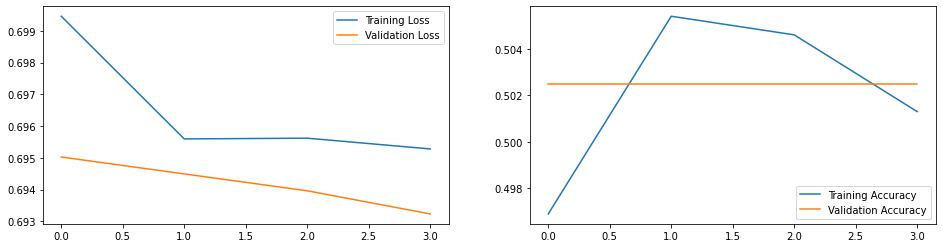

In [149]:
## Loss and acuracy
plot_history(history4)

In [150]:
test_pred4 = model4.predict(test_ds)
test_pred4 = np.argmax(test_pred4,axis = 1)
test_labels4 = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 1s 16ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

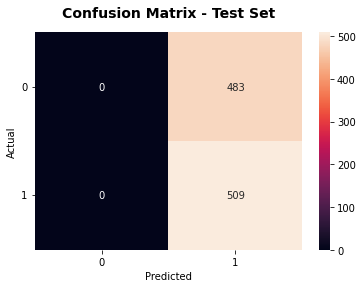

In [151]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels4,
    test_pred4,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [152]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 0 with mask and all 483 without mask

# Model 5

Sequential model

Input layer

Hidden layer 1: Dense 350 units, Relu activation

Hidden layer 2: Dense 550 units, Relu activation

Hidden layer 3: Dense 300 units, Relu activation

Hidden layer 4: Dense 100 units, Relu activation

Output layer: Dense 2 units, Softmax activation

In [153]:
model5 = Sequential()
tf.keras.layers.Rescaling(1./255),
model5.add(keras.layers.Flatten(input_shape = [256, 256, 3]))
model5.add(layers.Dense(units = 350, activation = "sigmoid"))
model5.add(layers.Dense(units = 550, activation = "sigmoid"))
model5.add(layers.Dense(units = 300, activation = "sigmoid"))
model5.add(layers.Dense(units = 100, activation = "sigmoid"))
model5.add(layers.Dense(name = "output_layer", units = 2, activation = "softmax"))

model5.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_17 (Flatten)        (None, 196608)            0         
                                                                 
 dense_48 (Dense)            (None, 350)               68813150  
                                                                 
 dense_49 (Dense)            (None, 550)               193050    
                                                                 
 dense_50 (Dense)            (None, 300)               165300    
                                                                 
 dense_51 (Dense)            (None, 100)               30100     
                                                                 
 output_layer (Dense)        (None, 2)                 202       
                                                                 
Total params: 69,201,802
Trainable params: 69,201,802

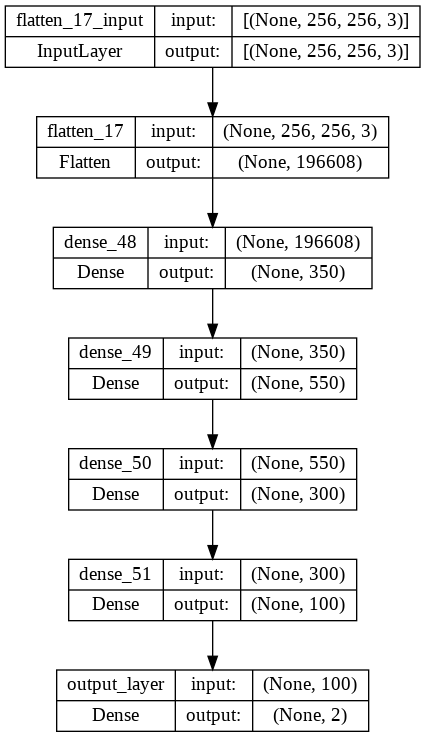

In [154]:
keras.utils.plot_model(model5, "model5.png", show_shapes=True) 

In [155]:
model5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [156]:
## Train 
history5 = model4.fit(train_ds
                    ,validation_data =validation_ds
                    ,epochs=200
                    ,batch_size=64
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model5.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                    ]                                                                                                           
                   )

Epoch 1/200
313/313 [==============================] - 5s 14ms/step - loss: 0.6949 - accuracy: 0.5019 - val_loss: 0.6927 - val_accuracy: 0.5025
Epoch 2/200
313/313 [==============================] - 5s 17ms/step - loss: 0.6947 - accuracy: 0.5023 - val_loss: 0.6925 - val_accuracy: 0.5025
Epoch 3/200
313/313 [==============================] - 4s 14ms/step - loss: 0.6947 - accuracy: 0.5036 - val_loss: 0.6924 - val_accuracy: 0.5025
Epoch 4/200
313/313 [==============================] - 4s 14ms/step - loss: 0.6946 - accuracy: 0.5032 - val_loss: 0.6923 - val_accuracy: 0.5025


In [157]:
model5 = tf.keras.models.load_model("DNN_model5.h5")
print(f"Test acc: {model5.evaluate(test_ds)[1]:.3f}")

31/31 [==============================] - 1s 17ms/step - loss: 0.6929 - accuracy: 0.5131
Test acc: 0.513


## Evaluate

In [158]:
history_dict5 = history5.history
history_dict5.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [159]:
history_df5=pd.DataFrame(history_dict5)
history_df5.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.695,0.502,0.693,0.502
1,0.695,0.502,0.693,0.502
2,0.695,0.504,0.692,0.502
3,0.695,0.503,0.692,0.502


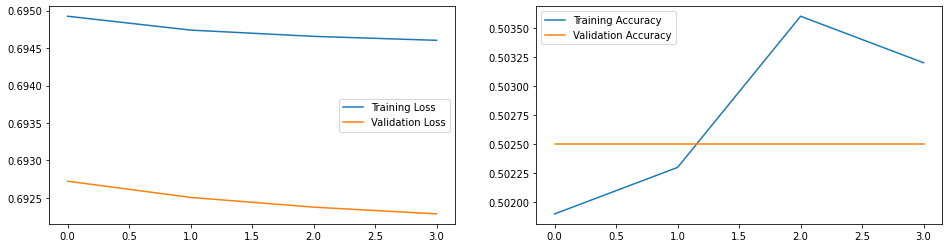

In [160]:
## Loss and acuracy
plot_history(history5)

In [161]:
test_pred5 = model5.predict(test_ds)
test_pred5 = np.argmax(test_pred5,axis = 1)
test_labels5 = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 1s 17ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

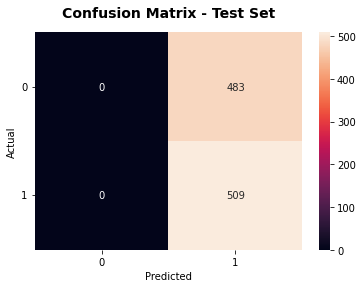

In [162]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels5,
    test_pred5,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [163]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 0 with mask and 483 without mask